# Monocular Visual Odometry — Deep Learning vs Traditional Methods

### Max McLaurin and Trevor Chartier

## Introduction & Problem Statement

**Visual Odometry** (VO) is the process of estimating the motion of a camera (or a camera-equipped vehicle) by analyzing the visual input it captures over time. By comparing sequential images, VO techniques extract information about the environment’s structure and the camera’s movement through it. 

**Monocular Visual Odometry** attempts to complete this task  using only a single sequence of images from a monocular (single-lens) camera. Unlike stereo or lidar based approaches, monocular VO must resolve motion and scale ambiguities from 2D image data alone. Creating a robust algorithm is a challenging computer vision task.

Here, we implement and evaluate two approaches to monocular visual odometry:

- **Classical (geometry-based):**  
  Relies on detecting and matching key visual features across frames, then applies geometric principles to estimate the camera’s movement. 

- **Deep learning-based approach:**  
  Uses neural networks trained on large datasets to learn patterns of motion directly from image sequences, in an end-to-end method.

The traditional visual odometry pipeline is developed from scratch using:
- SIFT feature extraction
- Feature matching with Lowe's ratio test
- RANSAC-based essential matrix estimation
- Incremental pose chaining

While this method performs well in textured environments, it degrades significantly under low-texture scenes, dynamic lighting, or repetitive structures—common in real-world driving datasets. These limitations motivated the exploration of learned models.

We then implemented two deep learning architectures for monocular VO using the KITTI Odometry benchmark:
1. **DeepVO**  
   A CNN-LSTM architecture that predicts relative camera motion directly from consecutive image pairs.
2. **Transformer-based DeepVO**  
   Replaces the LSTM with a lightweight temporal Transformer that includes a causal attention layer to smooth predictions and reduce drift over short sequences.

The deep-learning methods are compared against the classical SIFT-VO baseline to analyze the strengths and failure cases across both paradigms.

---

## Dataset
The **KITTI Odometry** dataset contains eleven driving sequences (00–10) of urban areas captured with:
- A single forward‑facing stereo camera rig  
- High‑precision GPS/INS ground truth  

**Characteristics:**
- Sequence lengths: 1–4 km  
- Environments: residential areas, highways, rural roads, underpasses  
- Challenges: changing illumination, dynamic objects, low‑texture regions (fields, tunnels)

**Train/Validation Split:**
- **Training:** 00, 01, 02, 05, 08, 09  
- **Validation:** 04, 06, 07, 10  
- **Held‑Out for Future Testing:** 03, 11  

This split balances route variety while providing over 9 000 overlapping subsequences for training high‑capacity networks.

---


### My Role in the Project Included:
- Implementing and Visualizing SIFT-Based VO
- DeepVO Training and Vizualization
- Comparing DeepVO and SIFT
- Calibrating and Applying SIFT to Custom Video


---

## Baseline: SIFT‑Based VO
We implemented a traditional pipeline using SIFT features and RANSAC‐based essential‐matrix estimation to recover frame‑to‑frame relative motion, followed by incremental pose chaining.

**Known Limitations of SIFT‑VO:**
- Feature matching fails (low‑texture roads or cylindrical poles)
- RANSAC rejection of true correspondences leads to “jumpy” motion
- Doesn't recover absolute scale

In [1]:
import cv2
import pandas as pd
import os
import matplotlib.pyplot as plt
import time
import numpy as np
import math
import glob
from IPython.display import display, clear_output
from PIL import Image
import time

In [ ]:
data_dir = "/s/bach/c/under/trevor04/Documents/Classes/CS445/Project/DeepVO-pytorch/KITTI/images"
calibration_dir = "/s/bach/c/under/trevor04/Documents/Classes/CS445/Project/Mono-VO-Classical/calibrations"
sequences = ['00','01','02','04','05','06','07','08','09','10']

Retrieve Camera Intrinsics From Calibration Files

In [ ]:
def get_camera_intrinsics(sequence):
    K = None
    calibration_path = os.path.join(calibration_dir, sequence, 'calib.txt')
    with open(calibration_path, 'r') as calib_file:
        for line in calib_file:
            if line.startswith('P3:'):
                K = np.array(line[4:].split(' ')).astype(float).reshape(3,4)[:,:3]
    return K

get_camera_intrinsics('07')

array([[707.0912,   0.    , 601.8873],
       [  0.    , 707.0912, 183.1104],
       [  0.    ,   0.    ,   1.    ]])

<function matplotlib.pyplot.show(close=None, block=None)>

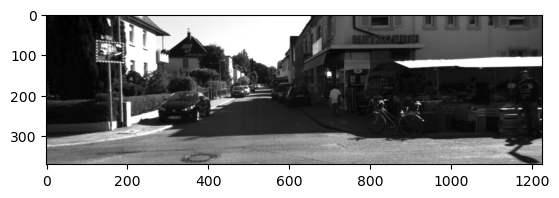

In [ ]:
def get_images_for_sequence(sequence):
    sequence_path = os.path.join(data_dir,sequence)
    frames = os.listdir(sequence_path)
    frames.sort()
    image_paths = [os.path.join(sequence_path, frame) for frame in frames]
    images = [cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2GRAY) for image_path in image_paths]
    return images

images = get_images_for_sequence('07')
plt.imshow(images[0], cmap='gray')
plt.show

Feature Detection With SIFT and Matching with FLANN

In [ ]:
sift = cv2.SIFT_create()
flann = cv2.FlannBasedMatcher(dict(algorithm=0, trees=5), dict(checks=50))

def get_SIFT_matches(image1, image2):
    keypoints1, descriptors1 = sift.detectAndCompute(image1, None)
    keypoints2, descriptors2 = sift.detectAndCompute(image2, None)
    matches = flann.knnMatch(descriptors1, descriptors2, 2)

    # Do a ratio test to reject weak matches
    good_matches = []
    for match in matches:
        if match[0].distance < (0.7 * match[1].distance):
            good_matches.append(match[0])
    return keypoints1, keypoints2, good_matches

Visualize Keypoints

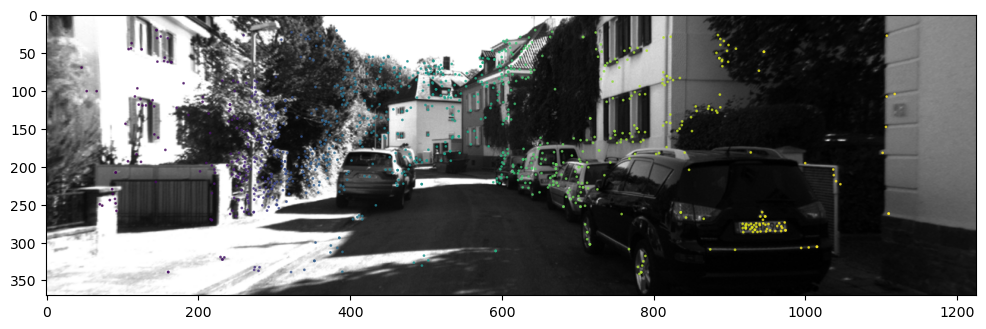

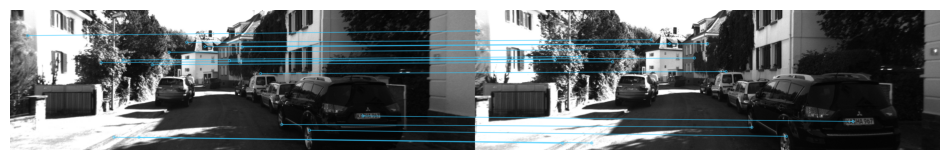

In [ ]:
def visualize_keypoints(img1, img2):
    keypoints1, keypoints2, matches = get_SIFT_matches(img1, img2)
    points1 = [keypoints1[match.queryIdx].pt for match in matches]
    points2 = [keypoints2[match.trainIdx].pt for match in matches]

    plt.figure(figsize=(12, 10))
    plt.imshow(images[index], cmap='gray')
    cols = range(len(points1))
    x,y = zip(*points1)
    plt.scatter(x,y, s=1, alpha=0.7, c =cols, cmap='viridis')
    plt.show;

    matched_image = cv2.drawMatches(
    images[index], keypoints1, images[index+1], keypoints2, matches[0:1000:70], None, 
    matchColor=(50, 200, 255), flags=2)

    plt.figure(figsize=(12, 6))
    plt.imshow(matched_image)
    plt.axis('off') 
    plt.show()


index = 210
img1 = images[index]
img2 = images[index+1]
visualize_keypoints(img1, img2)

Find essential matrix and extract rotation and translations

In [ ]:
def extract_rotation_translation(keypoints1, keypoints2, matches, K):
    points1 = [keypoints1[match.queryIdx].pt for match in matches]
    points2 = [keypoints2[match.trainIdx].pt for match in matches]
    E, mask = cv2.findEssentialMat(np.array(points1), np.array(points2), K, prob=0.999, threshold=1.0)
    _, R, t, mask = cv2.recoverPose(E, np.array(points1), np.array(points2), K)
    
    return R, t

Run Algorithm On All Images in Given Sequences

In [ ]:
def get_trajectory(images, K, results_path=None):
    R_total = np.eye(3)
    t_total = np.zeros((3, 1))
    trajectory = [t_total.copy()]
    
    if results_path is not None:
        with open(results_path, 'a') as file:
            file.write("0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0\n")
    for i in range(len(images) - 1):
        keypoints1, keypoints2, matches = get_SIFT_matches(images[i], images[i+1])
        R, t = extract_rotation_translation(keypoints1, keypoints2, matches, K)
        
        t_total += R_total @ t
        R_total = R @ R_total
        trajectory.append(t_total.copy())
        
        if results_path is not None:
            flattened_pose = np.hstack([R_total.flatten(), t_total.flatten()])
            with open(results_path, 'a') as file:
                file.write(", ".join(map(str, flattened_pose.tolist())) + "\n")
    return trajectory

In [ ]:
results_dir = "pose_results_test"
os.makedirs(results_dir, exist_ok=True)

trajectories = []

for sequence in sequences:
    results_path = os.path.join(results_dir, (sequence + ".txt"))
    images = get_images_for_sequence(sequence)
    K = get_camera_intrinsics(sequence)
        
    trajectory = get_trajectory(images, K)     
    trajectories.append(trajectory)

Plot Estimated Trajectory

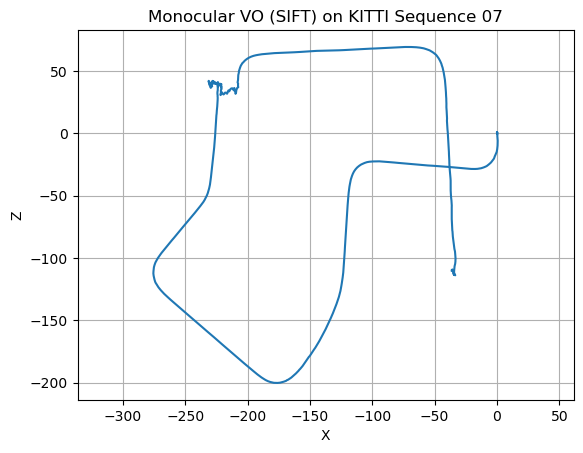

In [ ]:
idx = 6
trajectory = np.array(trajectories[idx]).squeeze()

plt.plot(trajectory[:, 0], trajectory[:, 2])  # X-Z plane
plt.xlabel('X')
plt.ylabel('Z')
plt.title(f'Monocular VO (SIFT) on KITTI Sequence {sequences[idx]}')
plt.axis('equal')
plt.grid(True)
plt.show()

DeepVO converts the 3x3 rotation matrix into Euler angles prior to training. In order for fair comparisons, we must also convert the predicted pose from SIFT into a 6D (x,y,z,pitch,roll,yaw) representation.

In [ ]:
# This code will not run in this environment as it makes use of functions from the DeepVO repository

def convert_sift_pose():
	videos = ["00", "01","02","04","05","06","07","08","09","10"]
	for video in videos:
		fn = '{}{}.txt'.format("../Mono-VO-Classical/pose_results/", video)
		print('Transforming {}...'.format(fn))
		with open(fn) as f:
			lines = [line.split('\n')[0] for line in f.readlines()] 
			poses = [ R_to_angle([float(value) for value in l.split(', ')]) for l in lines]  # list of pose (pose=list of 12 floats)
			poses = np.array(poses)
			base_fn = os.path.splitext(fn)[0]
			np.save(base_fn+'.npy', poses)
			print('Video {}: shape={}'.format(video, poses.shape))

## DeepVO

### Data Loading and Preprocessing

1. **Pose Extraction & Caching**
   - Trim frames before the first and after the last annotated pose
   - Convert 3×4 ground‑truth rigid‑body matrices → 6‑D vectors  
     `(θₓ, θ_y, θ_z, x, y, z)`  
   - Save as NumPy `.npy` for fast loading

2. **PyTorch `Dataset`**
   - Reads cached poses + image filenames  
   - For index `i`:  
     1. Load frames `i…i+L`  
     2. BGR → RGB, cast to `float32`  
     3. Subtract `0.5` offset, normalize by per‑channel mean & std  
     4. Stack consecutive pairs → 6‑channel tensor  

3. **Batching**
   - Wrap `Dataset` in `DataLoader`  
   - Use `SortedRandomBatchSampler` to group similar‑length sequences  
   - Multi‑worker + pinned memory for GPU throughput

### Training on 2 Sequences

At first, the full KITTI dataset was unable to fit into our CS machine disk quota, and the model took far too long to run without a GPU, so we used only the first two sequences, training on the longer 00 sequence and validating on the 01 sequence.

We utilize the pipeline in the DeepVO repository: https://github.com/ChiWeiHsiao/DeepVO-pytorch

We modify the parameters, the preprocessing, and main script to work with our version of the dataset.

As in the paper, we use the weights of an optical flow model called FlowNet (https://arxiv.org/abs/1612.01925) to initialize the CNN weights in the DeepVO architecture. We attempt to mimick the other hyperparameters described in the DeepVO paper including 200 epochs, and an Adagrad Optimizer. We use a learning rate of .0005 for the full 200 epochs instead of using early stopping and a learning rate of .001. To prevent overfitting, dropouts of 0.2 are introduced to all CNN layers except the last which has a dropout of 0.5. The RNN has a hidden layer size of 1000 with a dropout of 0.5. Sequences of images are passed through the network during training, with lengths ranging randomly between 5 and 7 frames. One such sequence constitutes a sample.  Finally, to speed up training, we downsample image sizes to 608x184 (from an original 1126x360), allowing a batch size of 8 to fit in our GPU memory.

Number of samples in training dataset:  2725

Number of samples in validation dataset:  652

Training took approximately 66 minutes on an NVIDIA RTX 4000

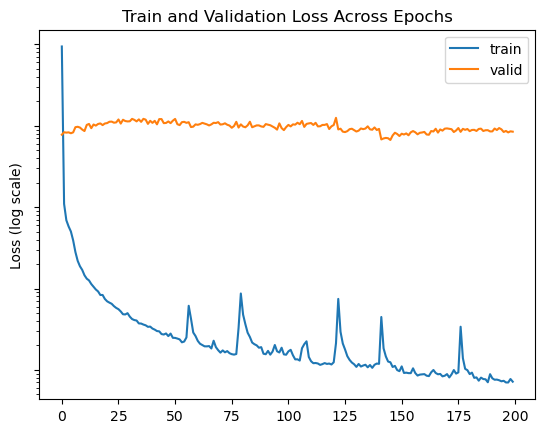

In [6]:
def plot_train_v_valid(log_file):
    train_loss = []
    valid_loss = []
    with open (log_file, 'r') as file:
        for line in file:
            if line.startswith("train loss"):
                train_loss.append(float(line[line.index(":") + 2:line.index(", std")]))
            elif line.startswith("valid loss"):
                valid_loss.append(float(line[line.index(":") + 2:line.index(", std")]))
                
    plt.figure()
    plt.plot(train_loss[:], label='train')
    plt.plot(valid_loss[:], label='valid')
    plt.title("Train and Validation Loss Across Epochs")
    plt.yscale('log')
    plt.ylabel('Loss (log scale)')
    plt.gca().set_yticklabels([])
    plt.legend()
    plt.show

log_file = "/s/bach/c/under/trevor04/Documents/Classes/CS445/Project/DeepVO-pytorch/result/partial_datset/train_may_1.log"   
plot_train_v_valid(log_file)

From this, it becomes immediately clear that training on one sequence was not enough to generalize anything useful. The validation loss has no improvement over training. 

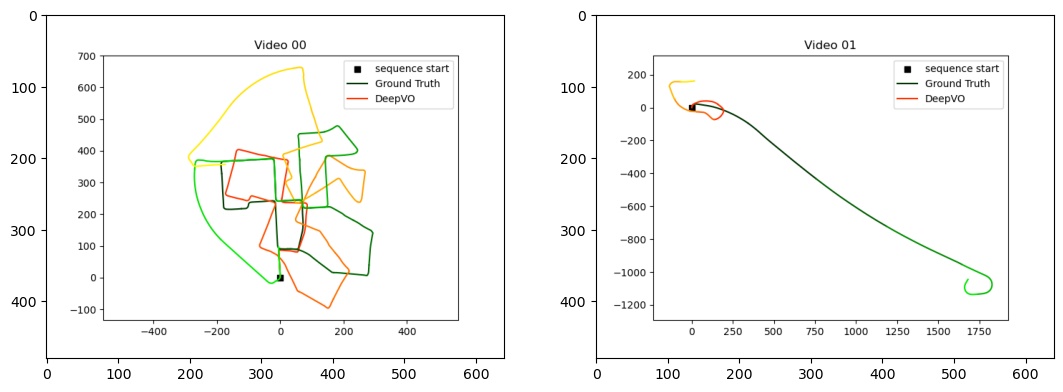

In [19]:
import matplotlib.image as mpimg

fig, axes = plt.subplots(1,2,figsize=(13,5))
img1 = mpimg.imread('/s/bach/c/under/trevor04/Documents/Classes/CS445/Project/DeepVO-pytorch/result/partial_datset/route_00_gradient.png')
axes[0].imshow(img1)
img2 = mpimg.imread('/s/bach/c/under/trevor04/Documents/Classes/CS445/Project/DeepVO-pytorch/result/partial_datset/route_01_gradient.png')
axes[1].imshow(img2)
plt.tight_layout
plt.show()

Despite the very poor generalization, it was cool to see the model learn (or memorize) some patterns in the training data.

SNA was kind enough to grant us a generous amount of extra disk quota, which made it feasible to train the model on the full dataset.

### Using the Full Dataset

Now, we train the model on seqences 00, 01, 02, 05, 08, and 09. We validate the model on sequences 04, 06, 07, and 10. This is in-line with what is described in the DeepVO paper: https://arxiv.org/abs/1709.08429. We utilize the same hyperparameters as before.

Number of samples in training dataset:  11217

Number of samples in validation dataset:  2177

Training took approximately 13 hours on an NVIDIA RTX4000.

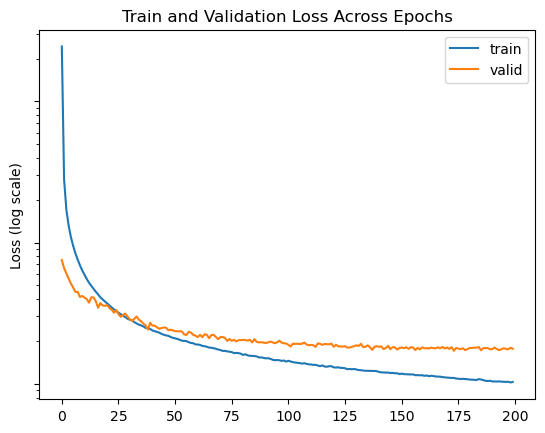

In [9]:
log_file = "/s/bach/c/under/trevor04/Documents/Classes/CS445/Project/DeepVO-pytorch/result/full_dataset_may_2/train_may_2.log"   
plot_train_v_valid(log_file)

This is a much better curve. It should be noted that the train loss is extremely large for the first couple epochs. As a result, we utilize a log scale on the y-axis. This makes the drop in validation loss less pronounced, although it can still be seen. Now that we have a model that appears to have trained somewhat successfully, we can begin comparing to our baseline.

## Comparing DeepVO and SIFT

In [21]:
deep_vo_path = "/s/bach/c/under/trevor04/Documents/Classes/CS445/Project/DeepVO-pytorch/result/full_dataset_may_2"
ground_truth_path = "/s/bach/c/under/trevor04/Documents/Classes/CS445/Project/DeepVO-pytorch/KITTI/pose_GT"
sift_path = "/s/bach/c/under/trevor04/Documents/Classes/CS445/Project/Mono-VO-Classical/pose_results"

model_paths = [deep_vo_path, ground_truth_path, sift_path]

train_video = ['00', '01', '02', '05', '08', '09']
valid_video = ['04', '06', '07', '10']

In [30]:
def get_trajectories(video):    
    gt_pose_filepath = os.path.join(ground_truth_path, video + '.npy')
    gt = np.load(gt_pose_filepath)
    
    deep_vo_filepath = os.path.join(deep_vo_path, f'out_{video}.txt')
    deep_vo_df = pd.read_csv(deep_vo_filepath, header=None)

    sift_filepath = os.path.join(sift_path, video + '.npy')
    sift = np.load(sift_filepath)
    
    return gt, deep_vo_df, sift

def plot_routes(gt, deep_vo_df, sift):
    plt.clf()
    plt.scatter([gt[0][3]], [gt[0][5]], label='sequence start', marker='s', color='k')

    x_gt = [v for v in gt[:, 3]]
    y_gt = [v for v in gt[:, 5]]
    plt.plot(x_gt, y_gt, color='black', alpha=0.8, label='Ground Truth', linestyle='-')

    x_deep_vo = deep_vo_df.iloc[:, 3]
    y_deep_vo = deep_vo_df.iloc[:,5]
    plt.plot(x_deep_vo, y_deep_vo, color='teal', alpha=0.8, linestyle='-', linewidth=1.5, label='Deep VO')

    x_sift = np.array([v for v in sift[:, 3]])
    y_sift = np.array([v for v in sift[:, 5]])
    plt.plot(x_sift, y_sift, color='#FF6F00', alpha=0.8, linestyle='-', linewidth=1.5, label='SIFT')
    plt.title(f"Comparison of Pose Estimates for KITTI Sequence {video}")
    plt.legend();
    plt.show()

Let's plot the different routes for the validation sequences

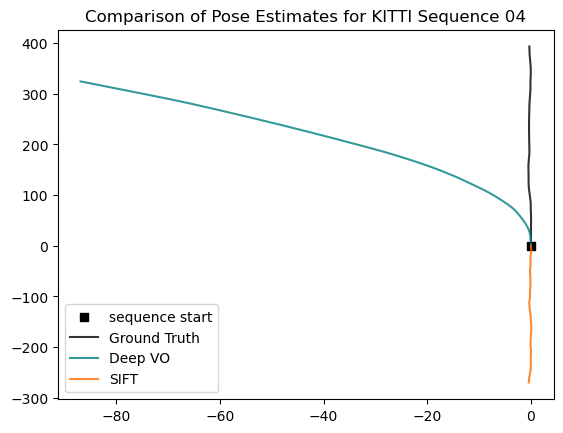

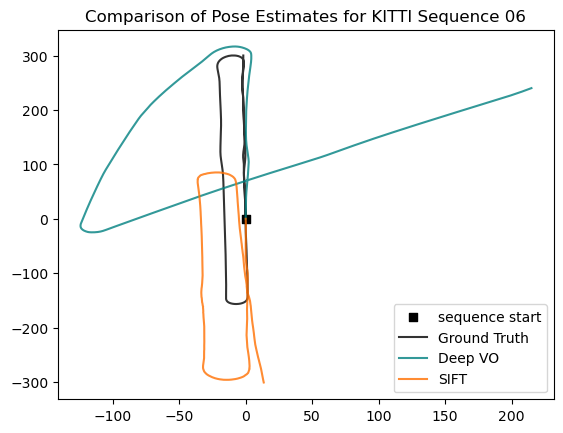

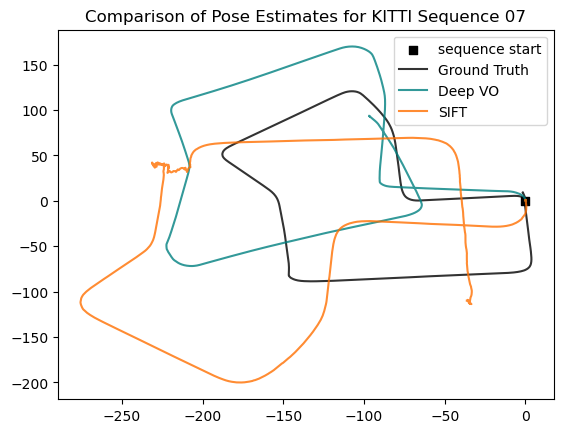

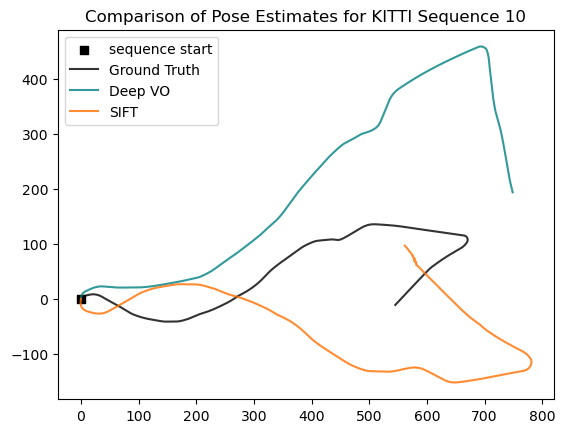

In [31]:
for video in valid_video:
    gt, deep_vo_df, sift = get_trajectories(video)
    plot_routes(gt, deep_vo_df, sift)

It's interesting to note how SIFT is unable to recover scale, and as such it appears reflected over the x-axis, wheras Deep VO is more accurate in this regard.

In [51]:
def compare_mse(videos):
    results = []
    for video in videos:
        gt, deep_vo_df, sift = get_trajectories(video)
        out = np.array(deep_vo_df)

        mse_rotate_deep = 100 * np.mean((out[:, :3] - gt[:, :3])**2)
        mse_translate_deep = np.mean((out[:, 3:] - gt[:, 3:6])**2)
        mse_rotate_sift = 100 * np.mean((sift[:, :3] - gt[:, :3])**2)
        mse_translate_sift = np.mean((sift[:, 3:6] - gt[:, 3:6])**2)

        results.append([
            video,
            np.round(mse_rotate_deep, 2),
            np.round(mse_rotate_sift, 2),
            np.round(mse_translate_deep, 2),
            np.round(mse_translate_sift, 2)
        ])

    columns = pd.MultiIndex.from_tuples([
        ("", "video"),
        ("MSE Rotate", "Deep VO"),
        ("MSE Rotate", "SIFT"),
        ("MSE Translate", "Deep VO"),
        ("MSE Translate", "SIFT"),
    ])

    df_results = pd.DataFrame(results, columns=columns)

    df_results.set_index(("", "video"), inplace=True)
    df_results.index.name = "Sequence"
    return df_results


compare_mse(valid_video)

MSE Rotate         MSE Translate          
            Deep VO    SIFT       Deep VO      SIFT
Sequence                                           
04             3.00    0.02        882.01  47334.27
06           285.50  280.72       3688.68  36429.81
07           113.62  377.83       1671.33   8836.60
10           260.85  410.63      16697.25  11136.98

SIFT sometimes outperforms DeepVO on rotational MSE, but due to the lack of abbsolute scale, the translational error of SIFT is consistently higher than DeepVO. 

Let's see how the training sequences look.

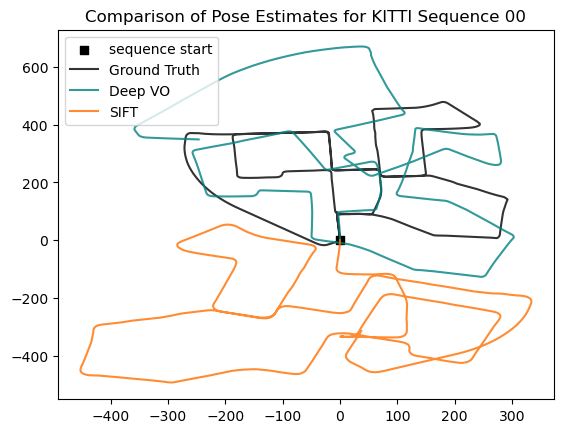

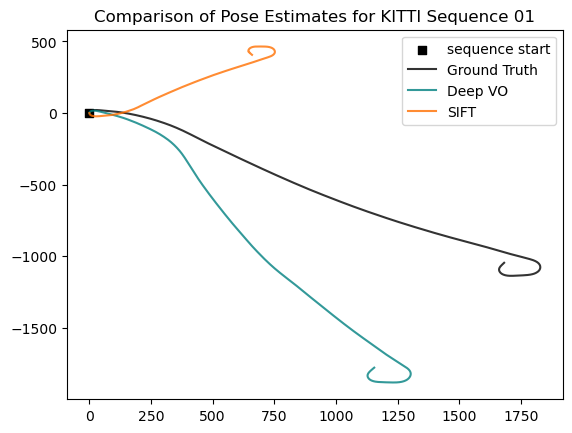

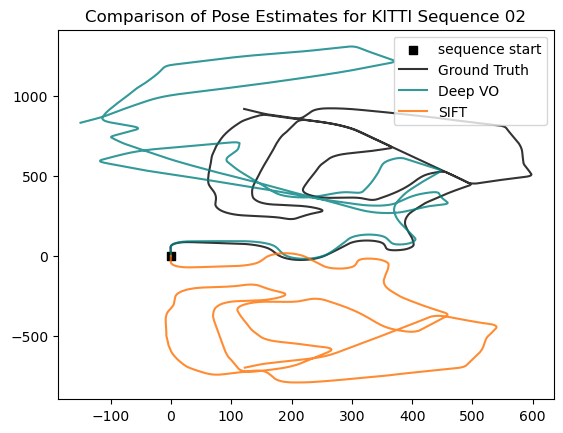

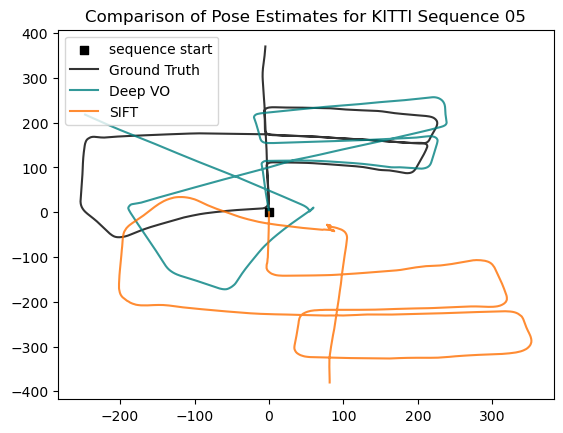

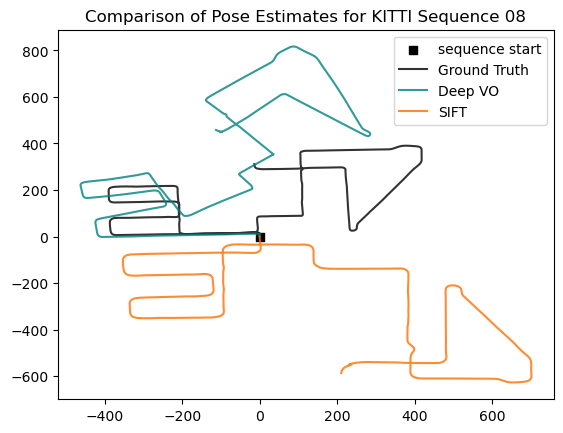

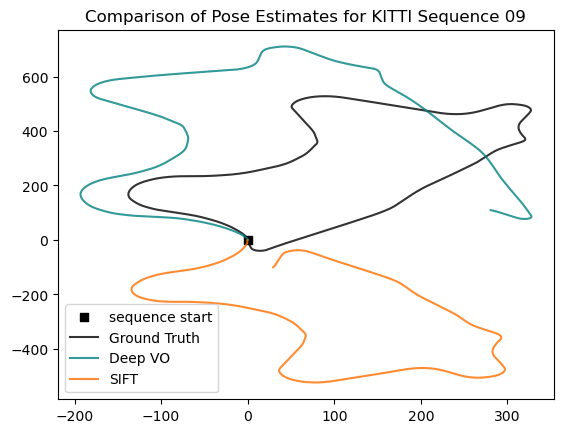

In [ ]:
for video in train_video:
    gt, deep_vo_df, sift = get_trajectories(video)
    plot_routes(gt, deep_vo_df, sift)

In [52]:
compare_mse(train_video)

MSE Rotate         MSE Translate           
            Deep VO    SIFT       Deep VO       SIFT
Sequence                                            
00           133.85  381.74      13724.18  122413.26
01            74.05  541.37     127573.81  500334.25
02           142.52  387.04      39080.29  374338.00
05            94.61  282.00       3337.10   47207.72
08           135.38  329.62      24640.49  115793.02
09           297.01  413.39      18145.39  139545.96

As you might expect, DeepVO performs better on the data it was trained on.

## DeepVO Using Transformer Architecture

While the LSTM aggregates information sequentially, it struggles to “remember” revisits to the same scene and to correct drift. We wanted to explore how a  lightweight Transformer with causal self attention can attend back over a short window of past frames effectively a learned loop closure mechanism allowing the model to smooth pose estimates when the camera returns to familiar viewpoints.

In [ ]:
class TemporalTransformer(nn.Module):
    def __init__(self):
        d = par.transformer_dim
        layer = nn.TransformerEncoderLayer(
            d, par.transformer_heads, d*4, par.transformer_dropout,
            batch_first=True, norm_first=True
        )
        self.encoder = nn.TransformerEncoder(layer, par.transformer_layers)
    def forward(self, x):
        x = PositionalEncoding(d)(x) 
        return self.encoder(x)

In [ ]:
# predict 6‑DOF deltas:
rel = self.head(attn)              # (B, T‑1, 6)
smoothed = refine_window(window=rel[:, t‑w+1:t+1], lam=par.loop_lambda)


By attempting to add causal self‑attention lets each time‑step attend to the previous loop window frames with masking we can learn loop closure. This damping prevents wild corrections, weighting the most recent prediction slightly toward past context. While attempting loop closure it was hard for an LSTM to decide what to pay attention to, focusing too much on current or recent scenes rather than what it had seen at the beggining of the route

# Transformer Parameters

We attempted this transformer in a seperate notebook but here were some of the metrics we impossed

In [ ]:
self.transformer_dim     = 256
self.transformer_heads   = 4
self.transformer_layers  = 2
self.transformer_dropout = 0.3

# Loop‑closure smoothing
self.loop_window        = 10
self.loop_lambda        = 1e-3

# Loss weights for SE(3)
self.rot_w = 100.0
self.trn_w = 1.0

self.epochs     = 200
self.batch_size = 16

self.optim = {
    'opt'          : 'Adam',
    'lr'           : 3e-4,
    'weight_decay' : 5e-4
}

# LR scheduling & early stopping
self.lr_scheduler               = 'plateau' 
self.scheduler_patience         = 5
self.scheduler_factor           = 0.5
self.scheduler_min_lr           = 1e-6
self.early_stopping_patience    = 50
self.min_delta                  = 1e-3

# When training this is pattern we started to see emerage <br>

Epoch 001  train μ=63298.693715 σ=36330.0373 | val μ=17462.476286 σ=5365.3452<br>
Epoch 005  train μ=55947.673124 σ=35304.6291 | val μ=14699.732379 σ=4776.3871<br>
Epoch 010  train μ=50434.263230 σ=32293.9716 | val μ=14581.639936 σ=5409.6147<br>

...<br>

Epoch 015  train μ=41879.702811 σ=28870.1739 | val μ=24772.334473 σ=6947.3249<br>
Epoch 016  train μ=39920.401601 σ=28921.8116 | val μ=27345.010577 σ=8000.5769<br>

...<br>

Epoch 020  train μ=32819.417595 σ=27321.5884 | val μ=29584.772289 σ=8539.0398<br>
Epoch 021  train μ=31967.727809 σ=27891.8672 | val μ=26172.690351 σ=8529.3888<br>

...<br>

Epoch 030  train μ=30241.457923 σ=27202.0045 | val μ=28406.002800 σ=7871.3146<br>
Epoch 031  train μ=28705.071435 σ=27216.8279 | val μ=28957.956830 σ=9733.9037<br>

...<br>

Epoch 049  train μ=29025.092926 σ=24310.6059 | val μ=24260.312780 σ=8922.0069<br>
Epoch 050  train μ=20552.768920 σ=19078.2516 | val μ=24798.770242 σ=8622.1624<br>

***Similar results for rest of training


## Note: Says "DeepVO" but is tranformer path
### (Forgot to change legend in visual)

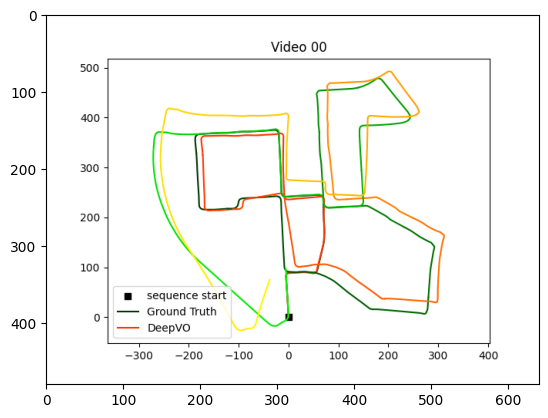

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
img = mpimg.imread('route_00_gradient.png')
plt.imshow(img)

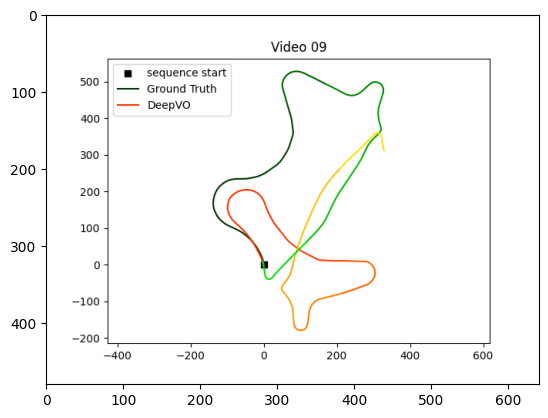

In [2]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
img = mpimg.imread('route_09_gradient.png')
plt.imshow(img)

## Transformer Interpretations

From this we can conclude a few things. It might be focusing too much on local motion (short-term cues) and not generalizing well to unseen or looped paths. We see early on the validation loss drops at first but then the validation loss quickly starts rising again while the training continues to drop.  Around epochs 15–20 training μ continues to drop down to ~32 k, but validation μ stalls and then climbs up to ~29–30k. And later epochs training μ keeps decreasing showing that our network fits the training data better and better—but validation μ oscillates higher, never matching that training improvement. This is clear signs of overfitting. We expermented with this a bit more but with this being both of our first times working with transformers we were unnsuccesful in getting it to ourperform DeepVO or SIFT

## Trying to Run SIFT On Our Own Video

For fun, we wanted to try and use SIFT on a video of our own. As another project, I converted an RC car to follow a line visually. I thought it'd be neat to see if SIFT would be able to capture the trajectory of the car from the on-board camera. 

In [3]:
video_path = "/s/bach/c/under/trevor04/Documents/Classes/CS445/Project/Mono-VO-Classical/videos/without_metrics.mp4"

cap = cv2.VideoCapture(video_path)
images = []

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    frame = frame[:400,:]
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    images.append(gray)

cap.release()

<function matplotlib.pyplot.show(close=None, block=None)>

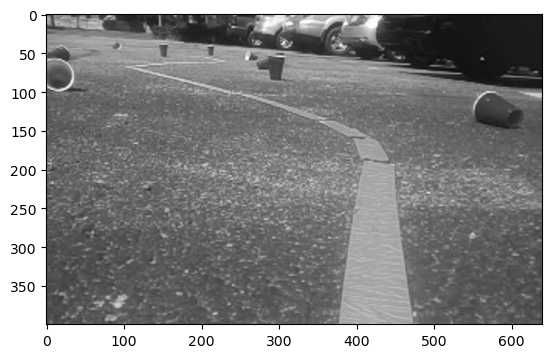

In [6]:
plt.imshow(images[0], cmap='gray')
plt.show

Here's the path that was followed in the video

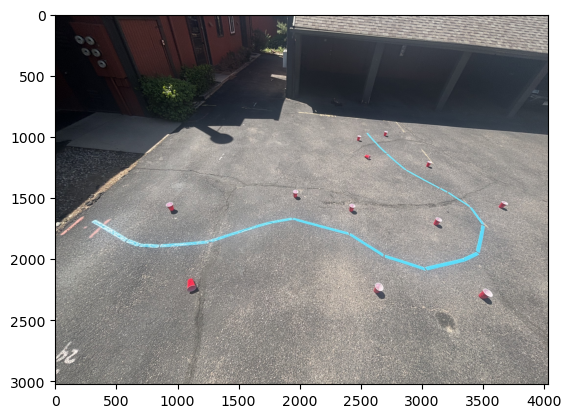

In [ ]:
img = mpimg.imread('/s/bach/c/under/trevor04/Documents/Classes/CS445/Project/Mono-VO-Classical/videos/path.png')
plt.imshow(img)


The seemingly scattered cups were in hopes of creating more features for the SIFT algorithm to use.

To be able to extract the essential matrix, we need to know the intrinsic parameters of our camera. With KITTI, this is easy, as it was provided. Using our own camera, we need to perform callibration using 10-20 images of a checkerboard to extract the intrinsic parameters.



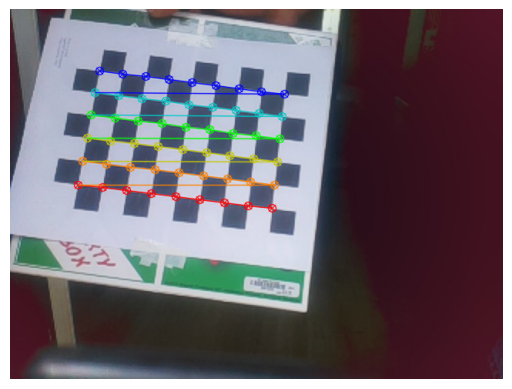

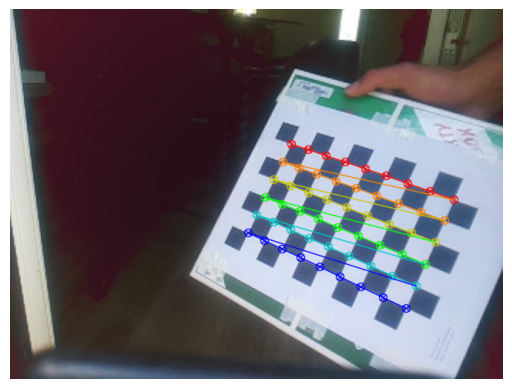

In [10]:
calibration_img_dir = "/s/bach/c/under/trevor04/Documents/Classes/CS445/Project/Mono-VO-Classical/arducam_calib_images"

## CODE TAKEN FROM OPENCV DOCS https://docs.opencv2.org/4.x/dc/dbb/tutorial_py_calibration.html (modified to work with 9x6 checkerboard)

# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
 
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((9*6, 3), np.float32)
objp[:, :2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2)
 
# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.
 
images = glob.glob(os.path.join(calibration_img_dir, "*.jpg"))
 
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
 
    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
 
    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)
 
        corners2 = cv2.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners2)
 
        # Draw and display the corners
        if "2" in fname:
            img = cv2.drawChessboardCorners(img, (9,6), corners2, ret)
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            plt.axis('off')
            plt.show()

In [11]:
_, K, _, _, _ = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
K # This is our camera's intrinsic matrix (used to extract the essential matrix later on)

array([[542.57624473,   0.        , 315.04618909],
       [  0.        , 544.52094434, 255.60348012],
       [  0.        ,   0.        ,   1.        ]])

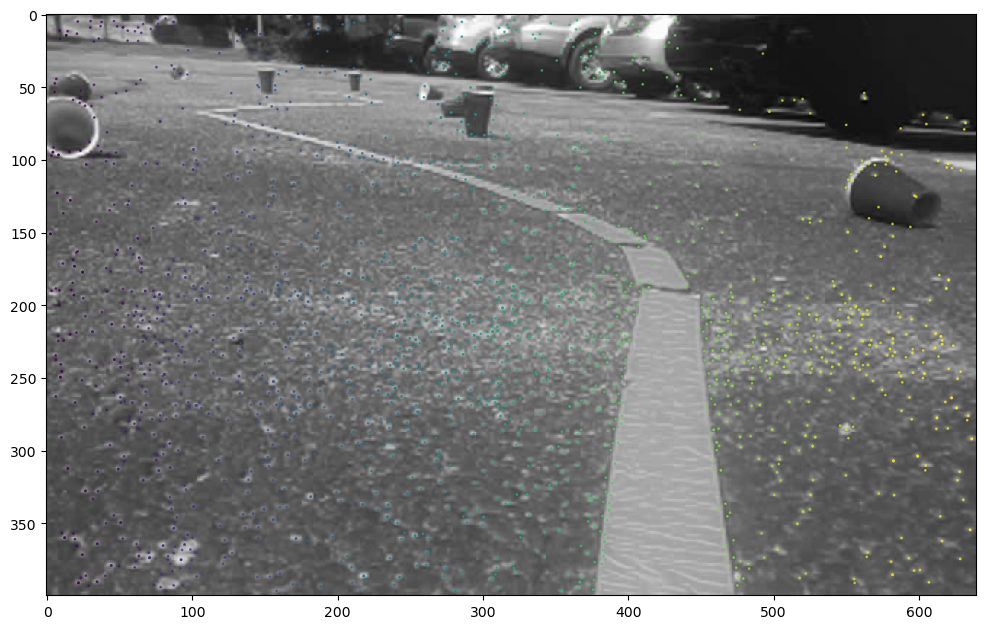

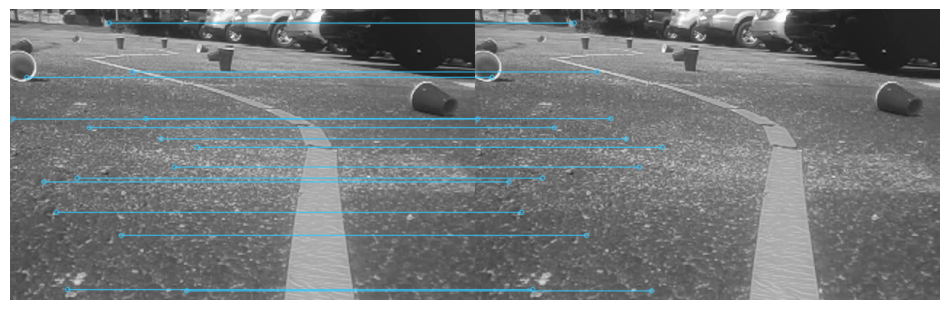

In [24]:
index = 0
img1 = images[index]
img2 = images[index+1]
visualize_keypoints(img1, img2)

In [27]:
trajectory = get_trajectory(images, K)

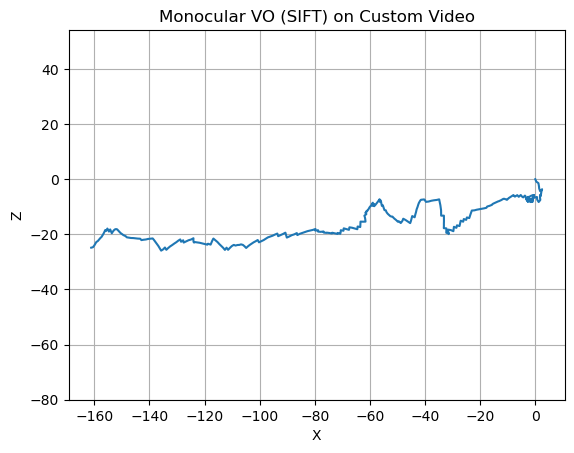

In [28]:
trajectory = np.array(trajectory).squeeze()
plt.plot(trajectory[:, 0], -trajectory[:, 2])  # X-Z plane
plt.xlabel('X')
plt.ylabel('Z')
plt.title(f'Monocular VO (SIFT) on Custom Video')
plt.axis('equal')
plt.grid(True)
plt.show()

Well, that didn't work very well. In hindsight, it makes sense that the performance is quite poor. We are using low resolution (480x640), in a low textured envrionment, turning quickly and the camera is pointed down to track the line. SIFT is unable to pick up on many very good features (things like buildings or signs) and the features it can choose are very close to the camera and don't stay in frame for long. Adding cups along the path to increase potential features for the SIFT algorithm doesn't seem to help much either. 

Given SIFT struggled with this environment, we were very confident that DeepVO would not be able to generalize to this task, given how different it is from the training data it has seen.